#### 14/09/2020
L'objectif est d'utiliser les requêtes pour donner un score à chaque terme-clé, pour savoir comment le TC contribue à rapprocher un document et une requête, mais surtout s'il contribue à rapprocher le document des requêtes pour lequel il est pertinent.
Une fois ce score établi, il sera possible de filtrer les termes-clés qui contribuent a rapprocher les documents de requêtes pour lesquels ils ne sont pas pertinents.

Faire correspondre les mots `w_d` des termes-clés du document `d` avec les requêtes (s'ils ont des mots en commun).
Puis compter le nombre de ces requêtes pour lesquelles le document `d` est pertinent.

- `d \app D` : document (ensemble de TC)
- `w_di \app d` : tc du document `d`
- `w_dij \app d` : le mot `j` du TC `i` du doc `d`
- `t \app T` : requête (topic) (ensemble de mots)
- `pert(d, t)` : qui dit si le document `d` est pertinent pour la requête `t` (défini par une liste document x requêtes)
- `sim(w_dij, t)` : qui dit le mot `w_dij` est lié à la requête `t` (là: `w_dij \app t`)
- `score(w_di)` : score de contribution du tc `w_di` a rapprocher le document `d` des requêtes `t \app T | pert(d,t) == True` dont il est pertinent
- `score(w_di) = \sum_{w_dij \ app w_di} \sum_{t \app T | sim(w_dij, t) > 0}{pert(d, t) * sim(w_dij, t)}`

- `pert(d, t)` : precision si d est pertinent avec 1 topic en général alors tout les TC seront "muavais"
- `sim(w_dij, t)` : couverture du score (si aucun mot n'est similaire a aucun topic alors on sais rien

Pour filtrer il faut faire par document et pas avoir de threshold général.


Faire un test avec KP20k pour voir.

Le but ici est de créer un référence (requêtes x document).
Idée de requête
- Utiliser le titre comme requête
- Utiliser les noun phrase du titre
- Les phrases citantes pour retrouver l'article cité

Cas possibles
- 1 req = 1 doc : très forte correlation entre topic et doc
- x req = 1 doc

Si 1 req = 1 doc alors il faut que les TC généré soient égal à la requête et en même temps différent des autres requetes, si il y a des requetes proches alors il faudra s'en éloigner donc peut-être 
Si 1 req = X doc

Ces couples (requête x document) vont être utilisés dans une loss.
L'idée est que grâce aux TC l'accuracy de RI doit augmenter.
L'accuracy serait un truc comme la cross entropy de la proba que le doc appartienne à la requete ou pas.
Est-ce que c'est dérivable si c'est à base de : est-ce que les termes de la requete sont dans les TC
Mais si c'est à base de cosine ça peut être ok, MAIS CONNE lors de l'entrainement on a pas de beam search, donc on sais pas quels sont les TC choisis.

In [1]:
import json
import nltk
import spacy
from tqdm import tqdm
import matplotlib.pyplot as plt
from operator import itemgetter
from multiprocessing import Pool
import numpy as np
from itertools import product
import seaborn as sns
from collections import Counter


Bad key text.latex.unicode in file /home/gallina-y/.local/lib/python3.6/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle, line 112 ('text.latex.unicode : False # use "ucs" and "inputenc" LaTeX packages for handling')
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.3.1/matplotlibrc.template
or from the matplotlib source distribution

Bad key savefig.frameon in file /home/gallina-y/.local/lib/python3.6/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle, line 423 ('savefig.frameon : True')
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.3.1/matplotlibrc.template
or from the matplotlib source distribution

Bad key pgf.debug in file /home/gallina-y/.local/lib/python3.6/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle, line 444 ('pgf.debug           : False')
You probably need to get an updated matplotlibrc file from
https:/

In [2]:
nlp = spacy.load('en', disable=["ner"])
stopwords = nltk.corpus.stopwords.words('english')

In [3]:
with open('../../data/datasets/KP20k/full/kp20k.valid.json') as f:
    data = map(json.loads, f)
    data = {d['id']: d for d in data}

Topics are the noun chunk extracted from the title of the doc (tokenized on space)
The abstract and keyword are indexed.
The relevance score is how many token of topics appear (exactly) in the document.

In [4]:
def worker(args):
    k, v = args
    acc = []
    for nc in nlp(v['title']).noun_chunks:
        for t in nc.text.split():
            if t.lower() not in stopwords and len(t) > 1:
                acc.append(t)
    return k, acc


topics = {}
with Pool(4) as p:
    for k, v in tqdm(p.imap_unordered(worker, data.items())):
        topics[k] = v

20000it [00:29, 677.35it/s]


In [5]:
def relevance_score(doc, topic):
    if not topic:
        return 0
    return sum(doc.get(t, 0) * n for t, n in topic.items()) / sum(topic.values())

In [6]:
def doc2content(doc):
    # Return the concatenation of tokens of the lowered abstract and of the tokens lowered
    tok_kws = [t for k in doc['keyword'].split(';') for t in k.lower().split()]
    return Counter(nltk.word_tokenize(doc['abstract'].lower()) + tok_kws)

In [9]:
preproc_data = [(k, doc2content(d)) for k, d in data.items()]
preproc_topics = [(k, Counter(map(str.lower, t))) for k, t in topics.items()]

In [11]:
def worker(args):
    docs, (t_id, topic) = (preproc_data, args)
    tmp = ((k, relevance_score(d, topic)) for k, d in docs)
    return t_id, [(k, s) for k, s in tmp if s > 0.5]

query2relevance = {}
with Pool(3) as p:
    for t_id, score in tqdm(p.imap_unordered(worker, preproc_topics),
                                  total=len(preproc_topics)):
        query2relevance[t_id] = score

100%|██████████| 20000/20000 [05:53<00:00, 56.54it/s]


In [69]:
# Requêtes qui retournent trop de résultat

In [ ]:
tmp = {k: (len(topics[k]), len({kd: s for kd, s in t.items() if s > 0.7}))
       for k, t in query2relevance.items()}
[(k, b, topics[k]) for k, (a, b) in tmp.items() if b > 150]

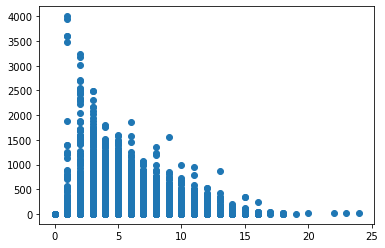

In [16]:
# Nombre de document pertinent en fonction du nombre de terme de la requete
tmp = {k: (len(topics[k]), len({kd: s for kd, s in t if s > 0.9}))
       for k, t in query2relevance.items()}
tmp = [(a, b) for a, b in tmp.values()]
plt.scatter([e[0] for e in tmp], [e[1] for e in tmp])
plt.show()

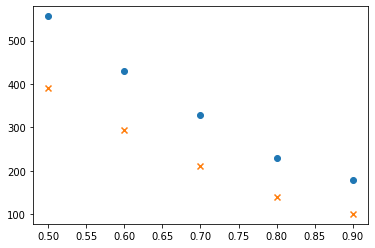

In [56]:
# En fonction du seuil quel est la moyenne du nombre de doc relevant
#  pour les requête qui retournent plus de 0 document qui n'est pas eux-même
%%time
tmp = []
# Pour accelerer après chque seuil supprimer les entrées qui sont < au seuil qu'on a calculé
for seuil in np.arange(0.5, 1, 0.1):
    seuil = round(seuil, 1)
    acc = (sum(s > seuil for k_d, s in t if k_d != k) for k, t in query2relevance.items())
    acc = [n for n in acc if n > 0]
    tmp.append((seuil, acc))

plt.scatter(x=[e[0] for e in tmp], y=[np.mean(e[1]) for e in tmp])
plt.scatter(x=[e[0] for e in tmp], y=[np.median(e[1]) for e in tmp], marker='x')
plt.show()

In [ ]:
# En fonction du seuil quel est le nombre de requetes qui retourne au moins 1 document ?
tmp = [(seuil, sum([sum(s > seuil for k_d, s in t if k_d != k) > 0 for k, t in query2relevance.items()]))
       for seuil in np.arange(0, 1, 0.1)]
plt.scatter(x=[e[0] for e in tmp], y=[e[1] for e in tmp])
plt.show()

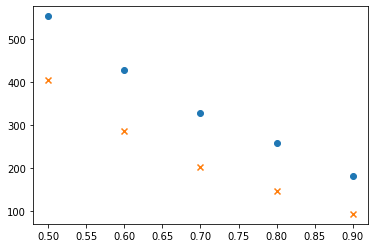

In [61]:
# En fonction du seuil combien de document lié a au moins 1 requetes qui n'est pas elle-même
tmp = []
for seuil in np.arange(0.5, 1, 0.1):
    doc_freq = Counter()
    for k_q, t in query2relevance.items():
        # Docs ok avec la requete k_q
        doc_freq.update([k for k, s in t if s > seuil and k != k_q])
    tmp.append((seuil, list(doc_freq.values())))
plt.scatter([e[0] for e in tmp], [np.mean(e[1]) for e in tmp])
plt.scatter([e[0] for e in tmp], [np.median(e[1]) for e in tmp], marker='x')
plt.show()

Choisir les requêtes:
    - je veux des requêtes qui retournent plusieurs documents (sans compter le document original)
    - 

In [ ]:
# En fonction du seuil combien de requetes retournent n documents
tmp = [(seuil, [sum(s > seuil for k_d, s in t if k_d != k) for k, t in query2relevance.items()])
       for seuil in np.arange(0.5, 1, 0.1)]

In [ ]:
df = pd.DataFrame((s, n) for s, l in tmp for n in l)

In [ ]:
df[1][df[1]> 0].describe()

In [ ]:
sns.violinplot(data=df[df[1]<20], x=0, y=1)

In [ ]:
df.loc[5]

In [ ]:
bins = [-1, 0, 1, 2, 3, 5, 10, 100, 20000]
df[2] = pd.cut(df[1], bins)
tmp = df[df[1]>0].groupby([0, 2]).count().unstack()

In [ ]:
tmp.index = [round(x, 2) for x in tmp.index]

In [ ]:
for l in tmp.iterrows():
    x = sns.lineplot(x=range(8), y=l[1][1], label=l[0])
x.set_xlabel(bins[2:])

Je choisis un seuil de 0.7, car la courbe est bien baissée mais on a still pas mal de requetes a plus de 1000 doc.

Il faut enlever les requetes qui retrounenent beaucoup trop de document.

In [ ]:
seuil = 0.7

In [ ]:
tmp = {k: {k_d: s for k_d, s in t if s > 0.7} for k, t in query2relevance.items()}

In [ ]:
[(k, topics[k]) for k, t in query2relevance.items() if len(t) > 1000]

In [ ]:
topics

In [40]:
topic_voc = Counter()
for ts in topics.values():
    for t in ts:
        topic_voc.update(t.split(' '))

In [31]:
kw_voc = Counter()
for kws in map(itemgetter('keyword'), data.values()):
    for kw in kws.split(';'):
        kw_voc.update(kw.split(' '))

In [48]:
len(set(kw_voc)), len(set(kw_voc) & set(topic_voc)) / len(set(kw_voc)) *100

(25171, 40.137459775138055)

## Etude du TF max des termes

En fait les termes les plus fréquents n'apparraissent que pour 5% max des requetes donc c'est ok pas de filtrage.

In [ ]:
from collections import Counter
# Est-ce que le DF peut être superieur à 1 ?
tmp = {t_id: {w: df for w, df in Counter(t).items() if df > 4} for t_id, t in topics.items()}
{k: v for k, v in tmp.items() if v}

In [ ]:
voc = {}
for v in topics.values():
    for t in set(map(str.lower, v)): # set car il peut y avoir plusieurs fois le même terme dans une requete
        if t not in voc:
            voc[t] = 0
        voc[t] += 1

In [ ]:
sorted([(t, f, f / len(topics)*100) for t, f in voc.items()], key=lambda x: x[1], reverse=True)

In [ ]:
tmp = [doc2content(d) for d in data.values()]
def worker(t):
    return t, sum(t.lower() in d.lower() for d in tmp)
doc_freq = {}
with Pool(5) as p:
    for t, f in tqdm(p.imap_unordered(worker, voc.keys()), total=len(voc)):
        doc_freq[t] = f

In [ ]:
sorted(doc_freq.items(), key=itemgetter(1), reverse=True)

In [ ]:
import re

In [ ]:
%%time
tmp = [doc2content(data[d]) for d in sorted(data)]
esc = lambda t: t.replace('\\', '\\\\').replace('(', '\(').replace(')', '\)').replace('*', '\*').replace('+', '\+').replace('?', '\?').replace('[', '\[').replace(']', '\]')
esc_voc = list(map(esc, sorted(voc)))

tf = [[(len(re.findall(t, d))) for t in esc_voc] for d in tmp]

In [ ]:
for d in document:
    for k in d.keyword:
        for t in topics:
            score = k in t * (1 if d in t.relevant else -1)
            